In [54]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from mambapy.mamba_lm import MambaLM, MambaLMConfig
from mambapy.mamba import Mamba, MambaConfig, RMSNorm
import ast
import DSA
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [55]:
config = load_config("../config.yaml")
taskset = "PDM"

In [56]:
def parse_model_info(model_name):
    model_name = model_name.replace(".pth", "")
    model_name = model_name.split("_")
    d_model = int(model_name[1])
    n_layers = int(model_name[2])
    learning_rate = float(model_name[3])
    batch_size = int(model_name[4])
    return d_model, n_layers, learning_rate, batch_size

In [57]:
def get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
):
    # Load configuration and set hyperparameters
    config = load_config("../config.yaml")
    ruleset = config[taskset]["rules_analysis"][-1]
    all_rules = config[taskset]["rules_analysis"]

    hp = {
        "num_epochs": 50,
        "batch_size_train": batch_size,
        "learning_rate": learning_rate,
        "l2_weight": 0.0001,
        "mode": "test",
    }
    hp, _, _ = main.set_hyperparameters(
        model_dir="debug", hp=hp, ruleset=all_rules, rule_trains=ruleset
    )
    config = MambaLMConfig(
        d_model=d_model,
        n_layers=n_layers,
        vocab_size=hp["n_input"],
        pad_vocab_size_multiple=1,  # https://github.com/alxndrTL/mamba.py/blob/main/mamba_lm.py#L27
        pscan=True,
    )
    run_model = main.load_model_mamba(
        f"../models/mamba/{taskset}/{group}/{model}",
        hp,
        config,
        device=device,
    )
    h = main.representation(run_model, all_rules, rnn=False)
    return h

### Get dynamics to plot

In [58]:
model = "mamba_8_1_0.01_32_train.pth"

#### Pretrain unfrozen

In [59]:
group = "master"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_master = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [60]:
group = "pretrain_frozen"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_pretrain_frozen = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [61]:
group = "pretrain_unfrozen"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_pretrain_unfrozen = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [62]:
group = "pretrain_basic_frozen"
device = "cpu"
d_model, n_layers, learning_rate, batch_size = parse_model_info(model)
curve_pretrain_basic_frozen = get_dynamics_mamba(
    d_model,
    n_layers,
    learning_rate,
    batch_size,
    model,
    group,
    taskset,
    device,
)

In [63]:
curves = [curve_master, curve_pretrain_frozen, curve_pretrain_unfrozen, curve_pretrain_basic_frozen]
# normalize all the curves
# for i in range(len(curves)):
#     curves[i] = (curves[i] - np.mean(curves[i])) / np.std(curves[i])

In [64]:
# reduce again curves to 3 components only to visualize
curves_reduced_to_plot, explained_variance = main.compute_common_pca(curves, n_components=3)

In [65]:
explained_variance

0.8206431081187187

#### Visualize the curves

In [66]:
# average each curve over second dimension
curves_averaged = [curve.mean(axis=1) for curve in curves_reduced_to_plot]
# curves_averaged = [curve for curve in curves_reduced_to_plot]

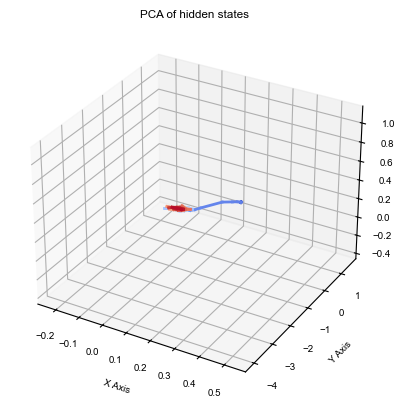

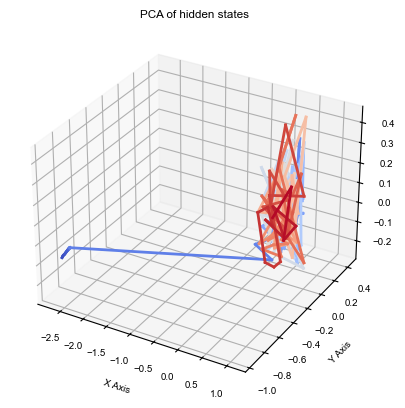

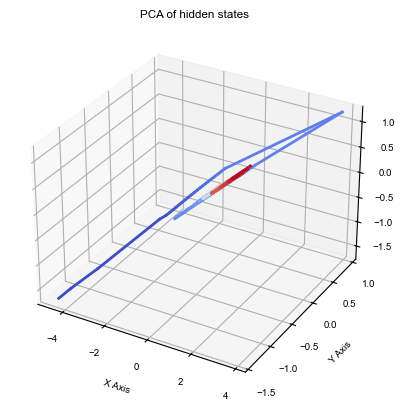

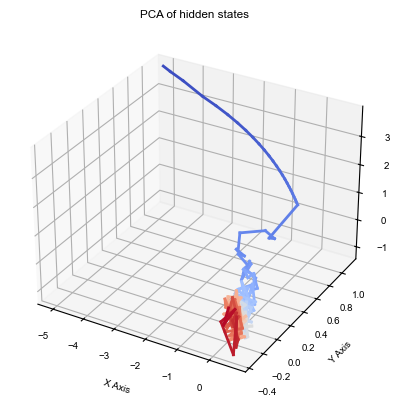

In [67]:
visualize(curves_averaged,title="PCA of hidden states")

In [68]:
dissimilarities = np.zeros((len(curves), len(curves)))
for i in range(len(curves)):
    for j in range(i, len(curves)):
        # compute DSA dissimilarity matrix
        # compute common pca between two curves
        curves_reduced, explained_variance = main.compute_common_pca(
            [curves[i], curves[j]], n_components=5
        )
        print(f"Explained variance between {i} and {j}: {explained_variance}")
        dsa_comp = DSA.DSA(
            curves_reduced[0],
            curves_reduced[1],
            # n_delays=config["dsa"]["n_delays"],
            n_delays=33,
            rank=100,
            # delay_interval=config["dsa"]["delay_interval"],
            delay_interval=6,
            verbose=True,
            iters=1000,
            lr=1e-2,
            device="cpu",
        )
        dis = dsa_comp.fit_score()
        dissimilarities[i, j] = dis

Explained variance between 0 and 0: 0.9999835326084541
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between 0 and 1: 0.9865350497271562
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between

In [69]:
for i in range(len(curves)):
    for j in range(i):
        dissimilarities[i, j] = dissimilarities[j, i]

<Axes: >

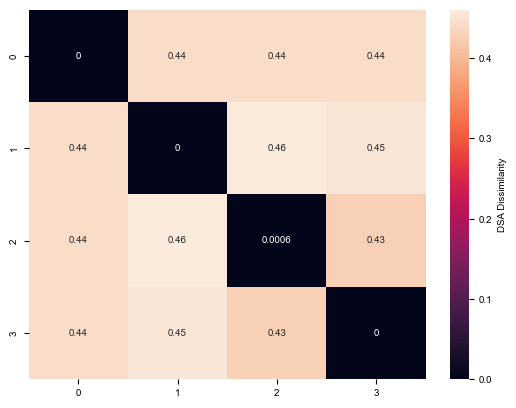

In [70]:
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})

In [71]:
curve_1 = curves[0]
curve_1.shape

torch.Size([200, 200, 8])

In [72]:
curve_1_reduce = curve_1.mean(axis=1)
curve_1_reduce.shape

torch.Size([200, 8])

In [78]:
dissimilarities = np.zeros((len(curves), len(curves)))
for i in range(len(curves)):
    for j in range(i, len(curves)):
        # compute DSA dissimilarity matrix
        # compute common pca between two curves
        curves_reduced, explained_variance = main.compute_common_pca(
            [curves[i], curves[j]], n_components=5
        )
        curves_reduced_mean =[curve.mean(axis=1) for curve in curves_reduced]
        print(f"Explained variance between {i} and {j}: {explained_variance}")
        print(curves_reduced_mean[0].shape)
        dsa_comp = DSA.DSA(
            curves_reduced_mean[0],
            curves_reduced_mean[1],
            # n_delays=config["dsa"]["n_delays"],
            n_delays=33,
            rank=100,
            # delay_interval=config["dsa"]["delay_interval"],
            delay_interval=3,
            verbose=True,
            iters=1000,
            lr=1e-2,
            device="cpu",
        )
        dis = dsa_comp.fit_score()
        dissimilarities[i, j] = dis

Explained variance between 0 and 0: 0.9999830383212124
(200, 5)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explained variance between 0 and 1: 0.9865528235344518
(200, 5)
Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

Computing Hankel matrix ...
Hankel matrix computed!
Computing SVD on Hankel matrix ...
SVD complete!
Computing least squares fits to HAVOK DMD ...
Least squares complete! 

computing similarity between DMDs 0 and 0
Finished optimizing C
Finished optimizing C
Explaine

<Axes: >

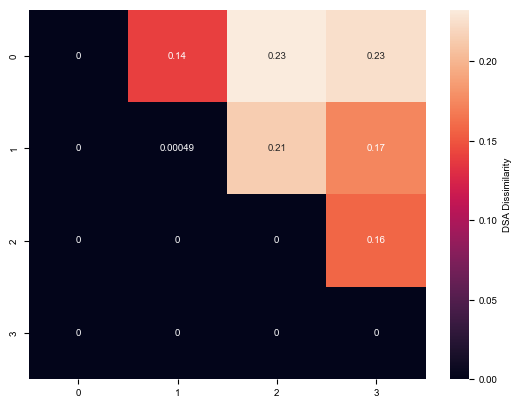

In [79]:
sns.heatmap(dissimilarities, annot=True, cbar_kws={"label": "DSA Dissimilarity"})